<a href="https://colab.research.google.com/github/peeyushsinghal/image-segmentation/blob/main/road_training_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Overview

This file represents the training pipeline file for algorithms / networks on massachusetts road dataset 
https://www.kaggle.com/insaff/massachusetts-roads-dataset

This file is written as .ipynb, but structured so that .py can also be created.
Instead of a separate configuration file, the file provides global / local declarations for easy readbility

the user can select the model architecture which is required to be trained

### Mounting Google Drive

For one  time use - Uncomment the function, for repeated "Run Alls"

In [ ]:
# from google.colab import drive
# # drive.flush_and_unmount()
# # drive.mount('/content/gdrive',force_remount=True)

# drive.mount('/content/gdrive')

### Importing Libraries

In [ ]:
# Importing Libraries
import tensorflow as tf
import numpy as np
import os # for file handing related purposes
import random # for generating random numbers and samples
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg # for reading image CHECK IF FINAL CODE USES THIS
import cv2 # for image processing

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks.experimental import BackupAndRestore
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


In [ ]:
print("TensorFlow Version: ", tf.__version__)


TensorFlow Version:  2.5.0


### Defining Constants

In [ ]:
#### CONSTANTS

SEED = 42 # for reproducing results
base_dir = '/content/gdrive/MyDrive/image-segment-dataset/massachusetts-roads-dataset/road_segmentation_ideal' # gdrive
SPLIT_RATIO = 0.15 # splitting training and validation, test is provided separately so no required
ORIGINAL_IMG_SIZE = 1500
MOBILENET_IMG_SIZE = 512
RESUNET_IMG_SIZE = 512
WEIGHTS =[0.05,0.95]



*   The image size is large, and the number of dataset is ok. Going for a smaller batch size as it trains the network better in lesser epochs

*   Using Epochs of 50 to train (compute restriction)
*   Learning rate - typical 1e-4 to start with, callbacks would reduce this on plateau







In [ ]:
#### Hyperparams for model

BATCH_SIZE = 4 

# EPOCH_CRASH_1 = 3              # model crashes after this, resurrected again
# EPOCH_CRASH_2 = 2*EPOCH_CRASH_1  # model crashes after this, resurrected again
# EPOCH_CRASH_3 = 3*EPOCH_CRASH_1  # model crashes after this, resurrected again
# EPOCH_CRASH_4 = 4*EPOCH_CRASH_1  # model crashes after this, resurrected again
# EPOCH_CRASH_5 = 5*EPOCH_CRASH_1  # model crashes after this, resurrected again
# EPOCH_CRASH_6 = 6*EPOCH_CRASH_1  # model crashes after this, resurrected again
# EPOCH_CRASH_7 = 7*EPOCH_CRASH_1  # model crashes after this, resurrected again
# EPOCH_CRASH_8 = 8*EPOCH_CRASH_1  # model crashes after this, resurrected again
# EPOCHS        = 9*EPOCH_CRASH_1  # final epoch
EPOCHS = 50
LEARNING_RATE = 1e-4

For reproducibility, setting seed upfront. Wherever random is used, seed is set then and there.

In [ ]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data Related Functions
These are divided into following set of functions

1.   Raw Data related functions
2.   Tensorflow Dataset (tf.data.Dataset) related functions
3.   Visualization Functions


### Raw Data related functions
Helper functions to 

*   Get all files in a directory based on extension type
*   Get full path of files
*   Get common files between two directories, ratio of common files to files in directory 1 and directory 2
*   Get files when the file index is provided
*   Split the files into training and validation based on split ratio





In [ ]:
## Dataset related Helper functions

def return_all_file_names(path,extn=".png"):
  '''function to return all file names having a chosen 
  extension in directory in a list'''
  all_files =[]
  for file in os.listdir(path):
      if file.endswith(extn):
        all_files.append(file)
  return all_files

def get_common_file_names(dir1,dir2):
  '''funtion to get the common file names between two directories, 
  ratio of common files to files in directory 1 and directory 2'''
  dir1_file_names = return_all_file_names(dir1)
  dir2_file_names = return_all_file_names(dir2)
  common_file_names = list(set(dir1_file_names)&set(dir2_file_names))
  ratio_dir1 = round(len(common_file_names)/len(dir1_file_names),2)
  ratio_dir2 = round(len(common_file_names)/len(dir2_file_names),2)
  return common_file_names,ratio_dir1,ratio_dir2

def get_file_paths(file_names,dir):
  ''' function to get all full file paths for file names in a direcctory'''
  file_path = []
  for fname in file_names:
    file_path.append(os.path.join(dir,fname))
  return file_path

def get_index_filepath(list_index,filepath):
  '''function  provides a list of file path, 
  if list of indices of file is provided '''
  list_filepath =[]
  for idx in list_index:
    list_filepath.append(filepath[idx])
  return (list_filepath)

def load_training_data_file_path(path,split_ratio = 0.15):
  
  '''Loads file paths of Training and Validation Data 
  (images and corresponding segmentation masks) from a directory path, 
  based on split ratio'''

  train_dir = os.path.join(path,'training') # base_dir is a global variable
  train_input_dir = os.path.join(train_dir,'input') # Images are kept 3 channel
  train_output_dir = os.path.join(train_dir,'output') # Corresponding Segmentatation Mask are kept here
  
  ### Getting common files, please note that the number of files in input dir and ouput dir is different
  common_file_names,_,_ = get_common_file_names(train_input_dir,train_output_dir)

  ### Splitting the data based on split ratio
  TRAIN_SET_SIZE= int((1-split_ratio)*len(common_file_names))
  VAL_SET_SIZE = len(common_file_names)-TRAIN_SET_SIZE

  ### Distributing the files in train and validate - based on split ratio, randomly distributing
  random.seed(SEED) # for reporducibility
  list_random_index_val = random.sample(range(0,len(common_file_names)-1),VAL_SET_SIZE) # Creating list of files (without full path) for validation (Random Sample)
  list_index_train = list(set(range(0,len(common_file_names)))-set(list_random_index_val)) # Getting all other files other than files in validation
  # print("intersection between train and validate data: ", list(set(list_random_index_val) & set(list_index_train))) # check to see there should not be any overlap

  train_input_file_path = get_file_paths(common_file_names,train_input_dir)
  train_ouput_file_path = get_file_paths(common_file_names,train_output_dir)

  train_x = get_index_filepath(list_index_train,train_input_file_path)
  train_y = get_index_filepath(list_index_train,train_ouput_file_path)

  val_x = get_index_filepath(list_random_index_val,train_input_file_path)
  val_y = get_index_filepath(list_random_index_val,train_ouput_file_path)

  return (train_x, train_y),(val_x,val_y)



### TO BE DELETED




In [ ]:
# def load_testing_data_file_path(path):
#   '''
#   Loads file paths of Testing Data (images and corresponding segmentation masks) from a directory path.
#   '''
#   test_dir = os.path.join(path,'testing') # base_dir is a global variable
#   test_input_dir = os.path.join(test_dir,'input') # Images are kept 3 channel
#   test_output_dir = os.path.join(test_dir,'output') # Corresponding Segmentatation Mask are kept here

#   test_input_file_names = return_all_file_names(test_input_dir,extn=".png")
#   test_output_file_names = return_all_file_names(test_output_dir,extn=".png")

#   # assert set(test_input_file_names) == set(test_output_file_names), " The files in input and output directory for testing is not same"

#   test_x = get_file_paths(test_input_file_names,test_input_dir)
#   test_y = get_file_paths(test_output_file_names,test_output_dir)

#   return (test_x,test_y)


### Tensorflow Dataset (tf.data.Dataset) related functions


In [ ]:

@tf.function
def process_img(img_path_x,img_path_y)->tuple:
  """
  Load an input image and corresponding output image and returning
  a dictionary after processing and transforming

  A>Normalize images
  B>Apply augmentation to input image
  Flip input and output images based on randomness
    1.Rotate Left Right 
    2.Rotate Up Down

  Parameters
  ----------
  string
        img_path_x: input image path
  string
        img_path_x: output image path
  Returns
  -------
  tuple
        tuple having an input image and output image
  """
  print ("process_img activated")

  # input_image = tf.io.read_file(img_path[0])
  input_image = tf.io.read_file(img_path_x)
  input_image = tf.image.decode_png(input_image, channels=3)
  input_image = tf.image.convert_image_dtype(input_image, tf.float64)
  # input_image = input_image / 255.0 # normalizing the image

  output_image = tf.io.read_file(img_path_y)
  output_image = tf.image.decode_png(output_image, channels=1)
  output_image = tf.image.convert_image_dtype(output_image, tf.float64)
  # output_image = output_image / 255.0  # normalizing the image

  #### Randomly understanding to flip or not
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    output_image = tf.image.flip_left_right(output_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_up_down(input_image)
    output_image = tf.image.flip_up_down(output_image)

  return input_image,output_image
  # return {'input_image': input_image, 'output_image': output_image}

@tf.function
def resize_img_mobilenet(img_x,img_y) -> tuple:
  '''
  resize image to size

  Parameters
  ----------
  Tuple
        Tuple of input image and output image

  Returns
  -------
  Tuple
        Tuple of resized input image and modified output image
  '''
  print ("resize_img activated")
  input_image = img_x
  output_image = img_y

  input_image = tf.image.resize(input_image, (MOBILENET_IMG_SIZE, MOBILENET_IMG_SIZE),method="nearest")
  output_image = tf.image.resize(output_image, (MOBILENET_IMG_SIZE, MOBILENET_IMG_SIZE),method="nearest")

  return input_image,output_image


@tf.function
def crop_img_mobilenet(img_x,img_y) -> tuple:
  '''
  crop image to size

  Parameters
  ----------
  Tuple
        Tuple of input image and output image

  Returns
  -------
  Tuple
        Tuple of cropped input image and modified output image
  '''
  print ("crop_img activated")
  input_image = img_x
  output_image = img_y
  
  original_size = tf.shape(img_x)[1]

  cropped_flag = tf.constant(0)
  counter = 0 
  while cropped_flag==tf.constant(0) and counter < 10 :
    counter +=1
    r = tf.random.uniform(shape=[], minval=0, maxval=original_size-MOBILENET_IMG_SIZE, dtype=tf.dtypes.int32)
    c = tf.random.uniform(shape=[], minval=0, maxval=original_size-MOBILENET_IMG_SIZE, dtype=tf.dtypes.int32)
    
    input_image = tf.image.crop_to_bounding_box(input_image, c, r, MOBILENET_IMG_SIZE, MOBILENET_IMG_SIZE)
    output_image = tf.image.crop_to_bounding_box(output_image, c, r, MOBILENET_IMG_SIZE, MOBILENET_IMG_SIZE)
    
    output_image = tf.where(output_image>0.0, 255*tf.ones_like(output_image), tf.zeros_like(output_image))

    y, idx, counts = tf.unique_with_counts(output_image)
    print (counts)

    count_one = tf.math.count_nonzero(output_image,dtype=tf.int32)
    count_zero = tf.size(output_image)-count_one

    ### Only taking those images which have a density higher than 5%
    if count_zero / (count_one +1) < 0.05 and counter < 10:
      continue
    else:
      cropped_flag = tf.constant(1)
  
  input_image = input_image / 255.0 # normalizing the image
  output_image = output_image / 255.0  # normalizing the image

  input_image = tf.image.resize(input_image, (MOBILENET_IMG_SIZE, MOBILENET_IMG_SIZE),method="nearest")
  output_image = tf.image.resize(output_image, (MOBILENET_IMG_SIZE, MOBILENET_IMG_SIZE),method="nearest")

  return input_image,output_image

In [ ]:
@tf.function
def process_test_img(img_path_x,img_path_y)->tuple:
  """
  Load an input image and corresponding output image and returning
  a dictionary after processing and transforming

  A>Normalize images

  Parameters
  ----------
  string
        img_path_x: input image path
  string
        img_path_x: output image path
  Returns
  -------
  tuple
        tuple having an input image and output image
  """
  print ("process_test_img activated")

  input_image = tf.io.read_file(img_path_x)
  input_image = tf.image.decode_png(input_image, channels=3)
  input_image = tf.image.convert_image_dtype(input_image, tf.float64)
  input_image = input_image / 255.0 # normalizing the image

  output_image = tf.io.read_file(img_path_y)
  output_image = tf.image.decode_png(output_image, channels=1)
  output_image = tf.image.convert_image_dtype(output_image, tf.float64)
  output_image = output_image / 255.0  # normalizing the image

  return input_image,output_image

### TO BE DELETED

In [ ]:

# def tf_parse(x, y):
#     def _parse(x_path, y_path):
#       x_path = x_path.decode()
#       x = cv2.imread(x_path, cv2.IMREAD_COLOR)
#       y_path = y_path.decode()
#       y = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
      
#       #### randomly flip images
#       flip_p = random.uniform(0, 1)
#       if (flip_p > 0.75) : 
#         # flipping vertically
#         x = numpy.array(list(reversed(x)))
#         y = numpy.array(list(reversed(y)))
#       if (flip_p < 0.25) : 
#         # flipping horizontally
#         x = numpy.array([list(reversed(row)) for row in x])
#         y = numpy.array([list(reversed(row)) for row in y])
#       ### Cropping image
#       img_height = MOBILENET_IMG_SIZE
#       img_width = MOBILENET_IMG_SIZE
#       num_splits = math.floor((y.shape[0]*y.shape[1])/(img_width*img_height))
#       # counter = 0
#       cropped_flag = 0 
#       while (cropped_flag == 1):
#         r = random.randint(0,y.shape[1]-img_height)
#         c = random.randint(0,y.shape[0]-img_width)
#       # for r in range(0,y.shape[1],img_height):
#       #   if cropped_flag == 1:
#       #     break
#       #   for c in range (0,y.shape[0],img_width):
#       #     counter += 1
#           # blank image and mask
#         blank_image = np.zeros((img_height ,img_width, 3), dtype = int)
#         blank_mask = np.zeros((img_height ,img_width), dtype = int)
#         # new image and mask
#         new_image = np.array(x[r:r+img_height, c:c+img_width,:])
#         new_mask = np.array(y[r:r+img_height, c:c+img_width])

#         blank_image[:new_image.shape[0], :new_image.shape[1], :] += new_image
#         blank_mask[:new_image.shape[0], :new_image.shape[1]] += new_mask

#         blank_mask[blank_mask>1] = 255

#         # Skip any Image that is more than 99% empty.
#         if np.any(blank_mask):
#           num_black_pixels, num_white_pixels = np.unique(blank_mask, return_counts=True)[1]
          
#           if num_white_pixels/num_black_pixels < 0.01:
#             continue
          
#           x = blank_image
#           y = blank_mask
#           cropped_flag = 1
#           break
        
#       x = x/255.0
#       y = y/255.0
#       y = np.expand_dims(y, axis=-1)

#       return x, y

#     x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
#     # x, y = tf.py_function(_parse, [x, y], [tf.float64, tf.float64])
#     return x, y

# def tf_dataset(x, y, batch=8):
#     dataset = tf.data.Dataset.from_tensor_slices((x, y))
#     dataset = dataset.map(tf_parse)
#     # dataset = dataset.batch(batch)
#     # dataset = dataset.repeat()
#     return dataset

### Visualization Functions

In [ ]:
def convert_to_rgb(img_filepath):
  ''' reads image and converts into RGB '''
  img = cv2.imread(img_filepath,1)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # by default cv2 reads files in BGR format, hence a conversion is required
  return img

def show_samples(dataset,num_sample=1,dataset_includes_file=False):
  '''
  Shows num_samples (default 1) samples of the dataset
  tf_flag=False => based on filename
  tf_flag=True => based on image
  '''
  fig=plt.figure(figsize=(16, 16))
  print(num_sample,"samples from the dataset")
  i=1
  columns=2
  for a,b in dataset.take(num_sample): 
    if dataset_includes_file == False:
      print(a)
    fig.add_subplot(num_sample, columns, i)
    if (dataset_includes_file == False):
      plt.imshow(plt.imread(a.numpy().decode("utf-8")))
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(a))

    fig.add_subplot(num_sample, columns, i+1)
    if (dataset_includes_file == False):
      plt.imshow(plt.imread(b.numpy().decode("utf-8")))
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(b))
    i=i+2
  plt.show()


## Models

Different types of Models are tried

1.   Unet Pretrained with MobilenetV2 Decoder : https://arxiv.org/abs/1801.04381v4: Pretrained models may reduce time to train the model, Mobilenet is the smallest model
2.   Unet Pretrained with ResUnet : https://arxiv.org/abs/1904.00592 ResUNet-a: a deep learning framework for semantic segmentation of remotely sensed data. Given that the paper is specially focussed for remotely sensed data, it is a good fit.




### Custom Metrics and Loss

*   Custom metrics, as there is no Intersection over Union (IoU) for single class, we have to create a custom function

*   Dice Coefficient (another perspective fo IoU) and Dice Loss used

In [ ]:
# Custom metrics, as there is no IOU for single class, we have to create a custom function

def metric_iou(y_true, y_pred):
  y_true = tf.keras.layers.Flatten()(y_true)
  y_pred = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true * y_pred)
  return ( intersection + K.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + K.epsilon())

# def loss_iou(y_true, y_pred):
#   return 1.0 - metric_iou(y_true, y_pred) # There is no literature which proves this may be incorrect

# Not using weighted_binary_crossentropy - using dice loss instead.
# This is based on the readings from the literature

def weighted_binary_crossentropy(y_true, y_pred):
    logloss = -(y_true * K.log(y_pred) * WEIGHTS[1]+ (1 - y_true) * K.log(1 - y_pred) * WEIGHTS[0])
    return (K.mean(logloss, axis=-1))

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + K.epsilon())

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

### Reusable UNET blocks

In [ ]:
## Reusable decoder blocks in Unet, while the encoders are pretrained decoder is constructed

def convolution_block(inputs, num_filters):
  x = inputs
  for i in range (0,2): # 2 convolution layers
    x = Conv2D(
        filters=num_filters, 
        kernel_size=3, 
        padding="same"
        )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
  return x

def decoder_block(inputs, skip_connection, num_filters):
  # x = Conv2DTranspose(filters=num_filters, kernel_size=2 , strides=2, padding="same")(inputs)
  x= UpSampling2D((2, 2))(inputs) # using Upsampling, as the number of trainable parameters is less than Conv2D
  x = Concatenate(axis=-1)([x, skip_connection]) # channel last axis concatenation
  x = convolution_block(x, num_filters)
  return x



### Model 1 :UNET with pretrained MobileNetV2


*   Pretrained Weights = imagenet
*   Encoder Backbone = MobileNetV2

Ideally the mobilenetv2 input requires the input data to be normalized between [-1,1], however in this case it is done as [0,1] as the same processing is used for multiple network architecture



In [ ]:
def unet_pretrained_mobilenetv2(input_image_size = (512,512,3)):

  ''' Contracting Path or Encoder'''
  inputs = Input(shape=input_image_size, name="input_image")
  
  encoder = MobileNetV2(
                        input_tensor=inputs,    # checked in keras documentation that warning, that default weights for 224 image size is loaded, is ok
                        weights="imagenet",     # pretrained weights
                        include_top=False,      # only CNN blocks required, no dense layer
                        alpha=0.35              # default alpha - making the model as light as possible, it represents number of filters more alpha means more params
                        )
  
  skip_connection_names = [
                           "input_image",         ## last layer for image_size in encoder.summary()
                           "block_1_expand_relu", ## last layer for image_size / 2
                           "block_3_expand_relu", ## last layer for image_size / 4
                           "block_6_expand_relu"  ## last layer for image_size / 8
                           ]

  '''Middle / Neck'''
  encoder_output = encoder.get_layer("block_13_expand_relu").output ## middle layer, image size / 16
  x = encoder_output

  ''' Expanding Path or Decoder'''
  filters = [int(input_image_size[1]/8), int(input_image_size[1]/4), int(input_image_size[1]/2), int(input_image_size[1])]
  # filters = [input_image_size/8, input_image_size/4, input_image_size/2, input_image_size]

  for i in range(1, len(skip_connection_names)+1, 1):
      skip = encoder.get_layer(skip_connection_names[-i]).output
      x = decoder_block(x,skip,filters[-i]) # channel last axis concatenation

  """ Output Layer """
  x = Conv2D(1, 1, padding="same", activation = 'sigmoid')(x)

  model = Model(inputs, x, name="unet_pretrained_mobilenetv2")
  return model

### Model 2 :RESIDUAL UNET or RESUNET 


*   Pretrained Weights = None
*   Encoder Backbone = Custom


In [ ]:

def batchnorm_relu(inputs):
    """ Batch Normalization & ReLU """
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters, strides=1):
    """ Convolutional Layers """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    """ Shortcut Connection (Identity Mapping) """
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    """ Addition """
    x = x + s
    return x

def decoder_block_resunet(inputs, skip_features, num_filters):
    """ Decoder Block for resunet """

    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x

def resunet(input_image_size = (512,512,3)):
    """ RESUNET Architecture """

    inputs = Input(input_image_size)
    ''' Contracting Path or Encoder'''
    """ Endoder 1 """
    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same")(inputs) # Addition with same channel

    s1 = x + s

    """ Encoder 2, 3 """
    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    '''Middle / Neck'''
    b = residual_block(s3, 512, strides=2)
    
    ''' Expanding Path or Decoder'''
    """ Decoder 1, 2, 3 """
    x = decoder_block_resunet(b, s3, 256)
    x = decoder_block_resunet(x, s2, 128)
    x = decoder_block_resunet(x, s1, 64)

    """ Output Layer """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)

    """ Model """
    model = Model(inputs, outputs, name="RESUNET")

    return model

## Main Function - Training Pipeline Orchestrator

In [ ]:
def training_pipeline_orchestrator(model_selected ='unet_pretrained_mobilenetv2'):
  print("Model Selected:",model_selected )
  
  #---------------------------------------------------------------#
  ### Loading training dataset (file paths) based on split ratio

  (train_x, train_y),(val_x,val_y)= load_training_data_file_path(base_dir,split_ratio = SPLIT_RATIO) # each element consits of input and output images
  TRAIN_SIZE= len(train_x)
  VAL_SIZE = len (val_x)
  print(f"The Training Dataset include {TRAIN_SIZE} images.")
  print(f"The Validation Dataset include {VAL_SIZE} images.")

  #---------------------------------------------------------------#
  ## Creating tf.dataset from train and validate data set from file paths (input and output files together)

  train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
  val_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_y))
  #---------------------------------------------------------------#
  ### Seeing samples of train and validate dataset (which have file paths) (uncomment to see)

  show_samples(val_dataset)
  show_samples(train_dataset)

  #---------------------------------------------------------------#
  ### Processing, Augmentating and Transformation on dataset images
  ### Reading Images, Normalizing them
  
  train_dataset = train_dataset.map(process_img,num_parallel_calls=tf.data.experimental.AUTOTUNE,deterministic=False)
  val_dataset = val_dataset.map(process_img,num_parallel_calls=tf.data.experimental.AUTOTUNE,deterministic=False)

  #---------------------------------------------------------------#
  ### Based on model selected, resizing the images (different models have different input sizes)
  # model_selected =  'unet_pretrained_mobilenetv2'

  if model_selected =='unet_pretrained_mobilenetv2' or model_selected =='resunet': # image sizes for unet_pretrained_mobilenetv2 and resunet are same
    # train_dataset = train_dataset.map(resize_img_mobilenet,num_parallel_calls=tf.data.experimental.AUTOTUNE,deterministic=False)
    # val_dataset = val_dataset.map(resize_img_mobilenet,num_parallel_calls=tf.data.experimental.AUTOTUNE,deterministic=False)
    train_dataset = train_dataset.map(crop_img_mobilenet,num_parallel_calls=tf.data.experimental.AUTOTUNE,deterministic=False)
    val_dataset = val_dataset.map(crop_img_mobilenet,num_parallel_calls=tf.data.experimental.AUTOTUNE,deterministic=False)
  
  print (" Train Dataset structure: ",train_dataset, " Train Dataset element specification: ", train_dataset.element_spec )
  print (" Validation Dataset structure: ",val_dataset, " Validation Dataset element specification: ", val_dataset.element_spec )
  
  #---------------------------------------------------------------#
  ### Seeing samples of train and validate dataset (which have images) (uncomment to see)
  show_samples(val_dataset,dataset_includes_file=True)
  show_samples(train_dataset,dataset_includes_file=True)

  #---------------------------------------------------------------#
  ### Creating dataset for performance

  train_dataset= train_dataset.batch(BATCH_SIZE).cache().repeat().prefetch(tf.data.experimental.AUTOTUNE) 
  val_dataset= val_dataset.batch(BATCH_SIZE).cache().repeat().prefetch(tf.data.experimental.AUTOTUNE) 

  print (" Train Dataset structure: ",train_dataset, " Train Dataset element specification: ", train_dataset.element_spec )
  print (" Validation Dataset structure: ",val_dataset, " Validation Dataset element specification: ", val_dataset.element_spec )
  
  # ---------------------------------------------------------------#
  ### Model creation
  
  if model_selected =='unet_pretrained_mobilenetv2':
    current_model = unet_pretrained_mobilenetv2(input_image_size = (MOBILENET_IMG_SIZE,MOBILENET_IMG_SIZE,3))
  if model_selected =='resunet':
    current_model = resunet(input_image_size  = (RESUNET_IMG_SIZE,RESUNET_IMG_SIZE,3))
  
  ### Model Summary
  current_model.summary()

  #---------------------------------------------------------------#
  ### Model Saving Directories
  model_dir = os.path.join(base_dir,'models') # models directory 
  model_save_dir = os.path.join(model_dir,str(model_selected)) # directory for the selected model
  model_check_point_dir = os.path.join(model_save_dir,'ckpt') # checkpoint directory for the selected model
  model_backup_dir = os.path.join(model_save_dir,'bkp') # backup directory for the selected model
  model_final_save_dir = os.path.join(model_save_dir,'model_save') # final save directory for the selected model

  dir_list = [model_dir,model_save_dir,model_check_point_dir,model_backup_dir,model_final_save_dir]

  for dir in dir_list:
    try:
      if not os.path.exists(dir):
        os.makedirs(dir)
    except:
      print("Problem encountered while creating model saving directories")

  print("model asset saving dirs\n", model_save_dir,"\n", model_check_point_dir,"\n",model_backup_dir,"\n",model_final_save_dir)
  
  #---------------------------------------------------------------#
  ### More "secondary" Hyperparameters, dependent on other parameters

  STEPS_PER_EPOCH  = TRAIN_SIZE // BATCH_SIZE
  VALIDATION_STEPS = VAL_SIZE // BATCH_SIZE 
  #---------------------------------------------------------------#
  ### Call backs

  # callback_early_stop : to stop training if the validation loss is not decreasing
  # callback_early_stop = EarlyStopping( monitor ="val_loss", patience = 20,
  #                                     mode = 'min',restore_best_weights= True)
  # a high patience as the model in initial time takes a lot of time to reduce the val_loss

  # callback_reduce_lr : to reduce learning rate in order not to shoot the minimum
  callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                         mode='min',patience=5, min_lr=0.001)

  # callback_model_save : to save the best model
  callback_model_save = ModelCheckpoint(filepath=model_final_save_dir,
                                        monitor='val_loss', mode = 'min', 
                                        save_best_only=True)
  
  # callback_backup_restore : to back up and train the model from previous to crashed epoch
  callback_backup_restore = tf.keras.callbacks.experimental.BackupAndRestore(backup_dir=model_backup_dir)

  
  # callbacks_model = [callback_early_stop,callback_model_save,callback_reduce_lr,callback_backup_restore]
  callbacks_model = [callback_model_save,callback_reduce_lr,callback_backup_restore] # not including early stopping callback


  #---------------------------------------------------------------#
  ### Compiling model after setting optimizers, loss and metrics
  opt = tf.keras.optimizers.Adam(LEARNING_RATE)
  metrics = [metric_iou, dice_coef, Accuracy(), Precision(), Recall()] # As required
  current_model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

  #---------------------------------------------------------------#
  ### Model Training

  print('Model Training Started')

  model_history =  current_model.fit(
                        train_dataset, epochs=EPOCHS,
                        validation_data=val_dataset,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_steps=VALIDATION_STEPS, 
                        callbacks = callbacks_model
                        )
  print(model_history.history)
  print('Model training completed, model to be saved')
  #---------------------------------------------------------------#
  ### Saving Model
  
  current_model.save(str(model_selected),model_final_save_dir,
                     include_optimizer=True,save_format='tf')

  print (str(model_selected),' model saved at ', model_final_save_dir)

  print("\n Training Pipeline Completed")

  return
 

Model Selected: resunet
The Training Dataset include 683 images.
The Validation Dataset include 121 images.
1 samples from the dataset
tf.Tensor(b'/content/gdrive/MyDrive/image-segment-dataset/massachusetts-roads-dataset/road_segmentation_ideal/training/input/img-309.png', shape=(), dtype=string)


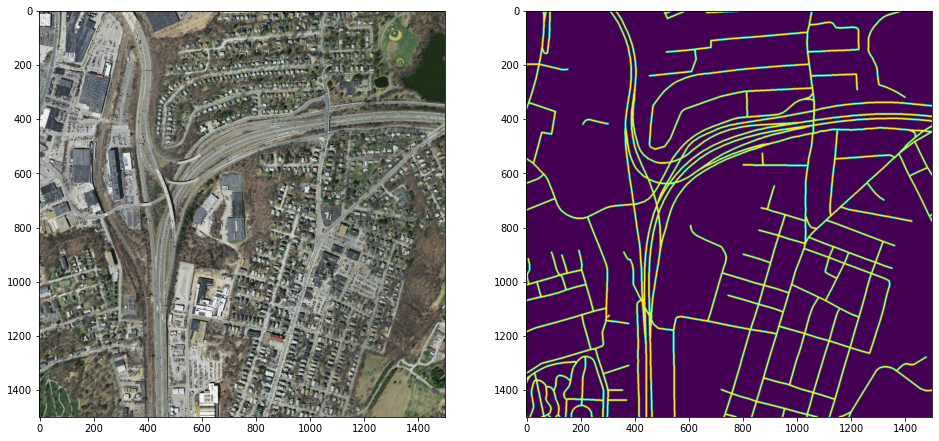

1 samples from the dataset
tf.Tensor(b'/content/gdrive/MyDrive/image-segment-dataset/massachusetts-roads-dataset/road_segmentation_ideal/training/input/img-820.png', shape=(), dtype=string)


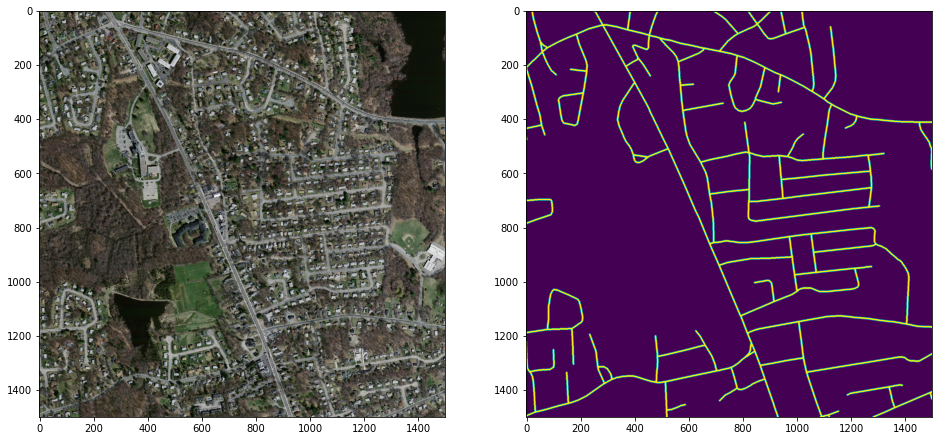

process_img activated
crop_img activated
Tensor("while/UniqueWithCounts:2", shape=(None,), dtype=int32)
 Train Dataset structure:  <ParallelMapDataset shapes: ((512, 512, 3), (512, 512, 1)), types: (tf.float64, tf.float64)>  Train Dataset element specification:  (TensorSpec(shape=(512, 512, 3), dtype=tf.float64, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.float64, name=None))
 Validation Dataset structure:  <ParallelMapDataset shapes: ((512, 512, 3), (512, 512, 1)), types: (tf.float64, tf.float64)>  Validation Dataset element specification:  (TensorSpec(shape=(512, 512, 3), dtype=tf.float64, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.float64, name=None))
1 samples from the dataset


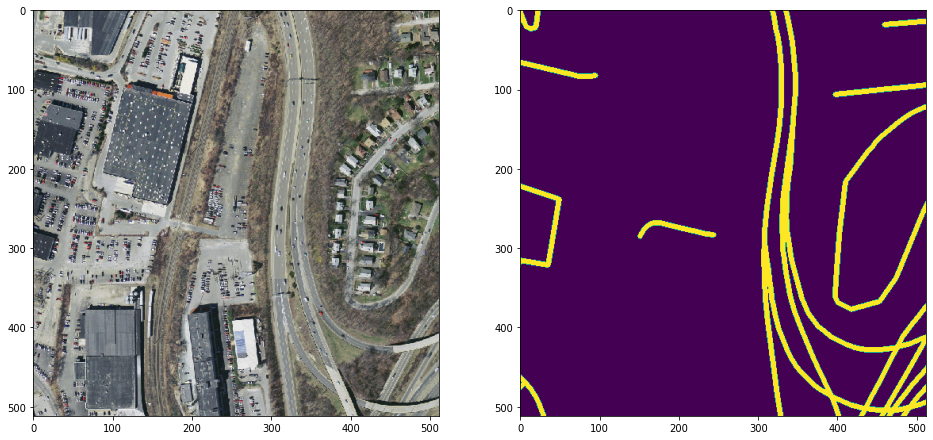

1 samples from the dataset


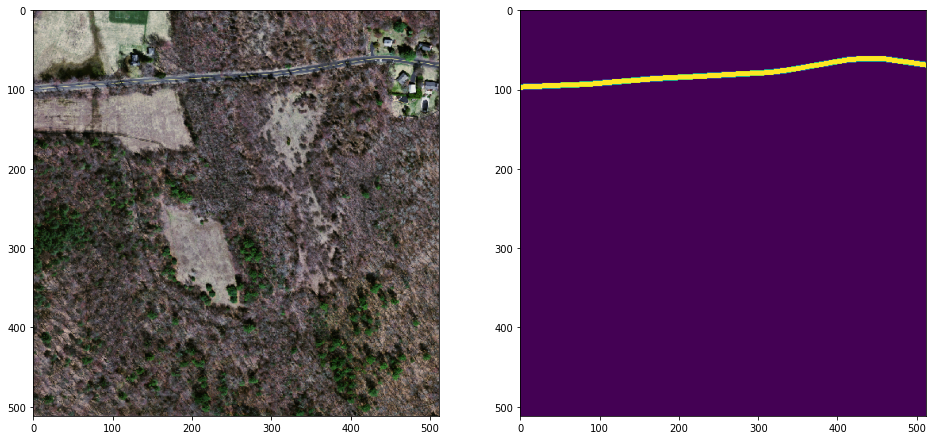

 Train Dataset structure:  <PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float64, tf.float64)>  Train Dataset element specification:  (TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float64, name=None))
 Validation Dataset structure:  <PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float64, tf.float64)>  Validation Dataset element specification:  (TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float64, name=None))
Model: "RESUNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________

In [36]:
if __name__ == '__main__':
  training_pipeline_orchestrator(model_selected ='resunet')
  # training_pipeline_orchestrator(model_selected ='unet_pretrained_mobilenetv2')

